<img src="https://github.com/d9w/evolution/raw/master/imgs/logo.png" width="20%" align="right" style="margin:0px 20px">


# Evolutionary Algorithms

## Symbolic Regression

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://d9w.github.io/evolution/">https://d9w.github.io/evolution/</a>

This notebook is partially adapted from Michael Littman's "Introduction to Machine Learning" [class](https://github.com/mlittmancs/great_courses_ml).

In this class, we will be exploring symbolic regression: the evolution of a symbolic function that inputs and outputs data. We will use the `gplearn` [package](https://gplearn.readthedocs.io/en/stable/).

In [1]:
!pip install gplearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.2/301.2 kB 1.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 2.5 MB/s eta 0:00:0000:0100:01


In [2]:
!pip install graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.7 MB/s eta 0:00:00


In [3]:
%matplotlib inline
from gplearn.genetic import SymbolicRegressor
from gplearn.genetic import SymbolicClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.random import check_random_state
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import graphviz

## Regression

In the first example, we will train a symbolic regression using genetic programming.  We will try to fit our model to a set of points.


First, we create the function for our data and make our training and test data with the function `fitme`. Given an input `x`, our target function will be a simple cubic function: $\frac{x^3}{10} + x^2$.

We’ll make a training set `X_train` for this function consisting of 50 `uniform` random `xs` between -10 and 10. We run these points through our target `fitme` function to get the corresponding targets, `y_train`.


In [23]:
def fitme(x):
    return 0.1*x*x*x + x*x

def fitme2(x):
    return np.sin(x*x/10) + np.cos(x/2)

# Training samples
X_train = np.random.uniform(-10, 10, (100,1))
y_train = [fitme(X) for X in X_train]
y_train2 = [fitme2(X) for X in X_train]

# Testing samples
X_test = np.random.uniform(-10, 10, (100,1))
y_test = [fitme(X) for X in X_test]
y_test2 = [fitme2(X) for X in X_test]

We will plot the data below

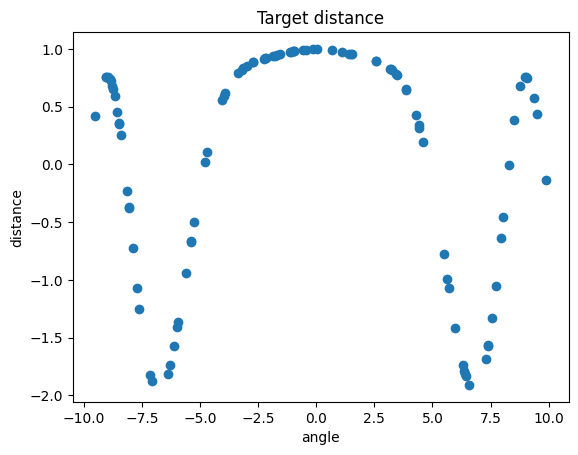

In [24]:
# plt.scatter(X_train, y_train)
plt.scatter(X_train, y_train2)
plt.title('Target distance')
plt.xlabel('angle')
plt.ylabel('distance')
plt.show()

Let's fit a model to this function using genetic programming. Our genetic-programming-based estimator, `est_gp` is a “symbolic regressor”. That is to say, we’re solving a regression problem by finding a symbolic expression --- a little piece of a program.

The program it finds will use only two operators: `add` for add and `mul` for multiply. A program can use as many of these operators as necessary. However, there’s a tradeoff in the search between accurately matching the training data and being parsimonious --- using a small expression.  The `parsimony_coefficient` tells the genetic programming search how much weight to put on parsimony (complexity) compared to accuracy. Parsimony coefficient can be any non-negative value, where smaller numbers for parsimony tend to result in much bigger programs created.

In [51]:
est_gp = SymbolicRegressor(population_size=10000,parsimony_coefficient=0.01,
                           function_set=('add', 'mul','sin','cos'))
#est_gp.fit(X_train, y_train)
est_gp.fit(X_train, y_train2)

/home/ugo/ISAE-SUPAERO/EvoAlgo/evolution/.conda/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SymbolicRegressor(function_set=('add', 'mul', 'sin', 'cos'),
                  parsimony_coefficient=0.01, population_size=10000)

We can now plot the performance of the model on the test set

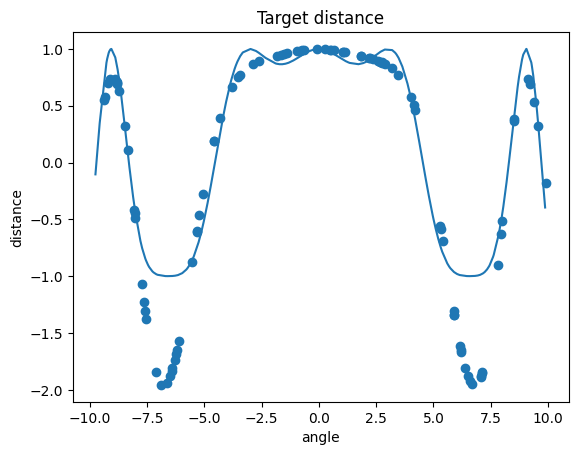

In [52]:
X_lots = np.reshape(np.sort(np.random.uniform(-10, 10, 250)),(-1,1))

y_gp = est_gp.predict(X_lots)

# plt.scatter(X_test, y_test)
plt.scatter(X_test, y_test2)
plt.plot(X_lots, y_gp)
plt.title('Target distance')
plt.xlabel('angle')
plt.ylabel('distance')
plt.show()

Finally we print the function learned by the genetic program below

In [53]:
print(est_gp._program)

cos(mul(mul(X0, -0.487), cos(mul(X0, -0.520))))


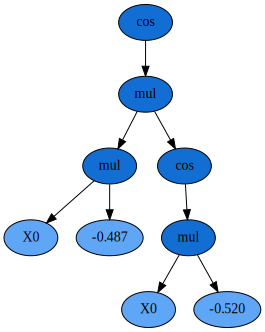

In [54]:
dot_data = est_gp._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph

We expect to find an expression that is similar to the original:  $\frac{x^3}{10} + x^2$. Do you?

Yes we do! not obvious but 
we find : 
x²  +  x²*0.409 * (0.122*2*x)

<div class="alert alert-success">
    <h3>Exercise 1</h3>

Change the function to $\sin(\frac{x^2}{10}) + \cos(\frac{x}{2})$. Can you reproduce this function using the same method? What parameters of the algorithm should change to make this easier?
</div>

We need to add the cos and sin functions (maybe one of the two suffice)
In the end, for this slightly more complex function, the algorithm doesn't converge to the true function. Nevertheless, the regression is fairly successful at approximating the true function.

## Classification

Let's now look at an example where we don't know what the underlying function is: data analysis. We will use a commonly studied problem of breast cancer detection. In medical applications such as cancer detection, explainability of the machine learning model is critical.

In [34]:
rng = check_random_state(0)
cancer = load_breast_cancer()
perm = rng.permutation(cancer.target.size)
cancer.data = cancer.data[perm]
cancer.target = cancer.target[perm]
cancer.data.shape

(569, 30)

The goal of this dataset is to determine if a cell is malignant or benign. The features are the following measurements of a cell nucleus, taken over three dimensions:

+ radius (mean of distances from center to points on the perimeter)
+ texture (standard deviation of gray-scale values)
+ perimeter
+ area
+ smoothness (local variation in radius lengths)
+ compactness (perimeter^2 / area - 1.0)
+ concavity (severity of concave portions of the contour)
+ concave points (number of concave portions of the contour)
+ symmetry
+ fractal dimension ("coastline approximation" - 1)

In [35]:
cancer.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [36]:
est = SymbolicClassifier(parsimony_coefficient=.01,
                         feature_names=cancer.feature_names,
                         random_state=1)
est.fit(cancer.data[:400], cancer.target[:400])

SymbolicClassifier(feature_names=array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23'),
                   parsimony_coefficient=0.01, random_state=1)

The fitting process can be long, but let's see how the evolved model performs on unseen data:

In [37]:
y_true = cancer.target[400:]
y_score = est.predict_proba(cancer.data[400:])[:,1]
print('\n'.join([str((y_true[i], y_score[i])) for i in range(5)]))
roc_auc_score(y_true, y_score)

(1, 0.9873332361979521)
(1, 0.993255871758674)
(1, 0.08994376691335697)
(0, 0.304637276256251)
(0, 0.6020689845915099)


0.9693786982248521

This is a good accuracy! We can also see that the probabilities usually match the classification, although there are some incorrectly classified cases. Let's see if we can use the graph to understand how classification is being performed.

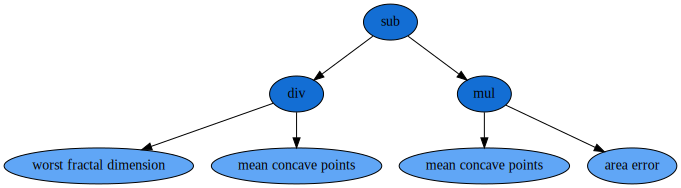

In [42]:
dot_data = est._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph


A different type of explainable machine learning model is the Decision Tree. We won't get into the details of how they're made, but feel free to look at the [scikit-learn documentation](https://scikit-learn.org/stable/modules/tree.html) for more information. Decision Trees use information theory to split features at relevant points in order to construct rules based on inequalities.

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

In [44]:
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=2)
decision_tree = decision_tree.fit(cancer.data[:400], cancer.target[:400])

In [45]:
y_true = cancer.target[400:]
y_score = decision_tree.predict_proba(cancer.data[400:])[:,1]
print('\n'.join([str((y_true[i], y_score[i])) for i in range(5)]))
roc_auc_score(y_true, y_score)

(1, 0.9788135593220338)
(1, 0.9788135593220338)
(1, 0.9788135593220338)
(0, 0.00847457627118644)
(0, 0.00847457627118644)


0.9548076923076924

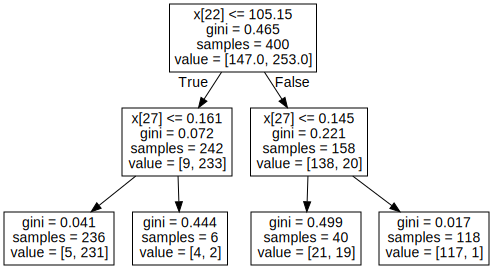

In [46]:
import graphviz 
dot_data = export_graphviz(decision_tree, out_file=None) 
graph = graphviz.Source(dot_data) 
graph

<div class="alert alert-success">
    <h3>Exercise 2</h3>

As we can see, the GP graph uses a number of different functions, like multiplication and addition, in its tree, where the Decision Tree uses inequalities. Which leads to higher explainability, in your opinion? Discuss in groups.
</div>

Inequalities have higher explainability, useful in medical applications where understanding is important.

<div class="alert alert-success">
    <h3>Bonus Exercise</h3>

Try tuning the parameters of the GP training. If you allow for larger trees, does this result in better models in terms of test accuracy?
</div>

todo, but probably not necessarily...